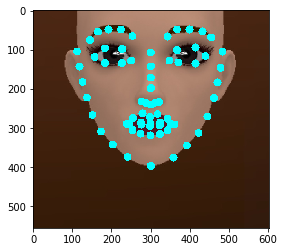

In [51]:
%matplotlib inline

import json
import cv2
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

from facetrackinglib.tensorflow.TFInference import TFInference

ftlib_dir = './facetrackinglib/tensorflow/'
face_detector = cv2.CascadeClassifier(os.path.join(ftlib_dir, 'models/haarcascade_frontalface_default.xml'))
refined_landmark_inference = TFInference(model_path = os.path.join(ftlib_dir, 
                                                                   
                                                                  #'models/faceoff_kao_onet_64x64x3_face_56_face_136_batch_32_random_hflip_False_reduce_lr_0.5.600-0.39-0.48.hdf5.pb'
                                                                  'models/faceoff_kao_onet_96x96x3_face_84_face_136_batch_32_random_hflip_False_reduce_lr_0.5.538-0.59-0.74.hdf5.pb',
                                                                  # '3d model'
                                                                #'models/faceoff_kao_onet_96x96x3_face_84_face_136_batch_32_random_hflip_False_reduce_lr_0.5.677-0.51-0.65.hdf5.pb', 
                                                                   # Non-3d models that performs poorly
                                                                  #'models/faceoff_kao_onet_64x64x3_face_56_face_136_batch_32_random_hflip_False_reduce_lr_0.5.464-0.26-0.26.hdf5.pb'                                                         
                                                                  #'models/faceoff_kao_onet_64x64x3_face_56_face_136_batch_32_random_hflip_False_reduce_lr_0.5.345-0.26-0.26.hdf5.pb'
                                                                  ),
                                         input_name = 'import/input_1',
                                         output_names = ['import/output_node0'])
refined_landmark_target_size = refined_landmark_inference.input_shape[0:2]

# landmark_json = '/Users/azhong/a.json'
# img_path = '/Users/azhong/facemaker/explore_face/basehead.jpg'
landmark_json = '/Users/azhong/b.json'
img_path = '/Users/azhong/facemaker/explore_face/basehead_nolighting.jpg'



pts = json.load(open(landmark_json))[0]['annotations']
landmarks = []

for pt in pts:
    landmarks.append([int(pt['x']), int(pt['y'])])

bgr_img = cv2.imread(img_path)
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
rgb_img_vis = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
assert(len(landmarks)) == 68
for pt in landmarks:
    cv2.circle(rgb_img_vis, (int(pt[0]), int(pt[1])), 10, (0, 255, 255), -1)
#     plt.imshow(rgb_img_vis)
#     plt.show()
plt.imshow(rgb_img_vis)
plt.show()

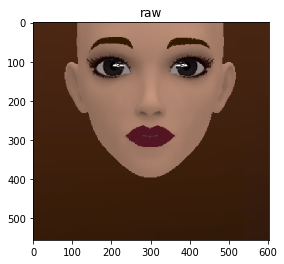

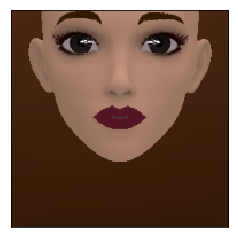

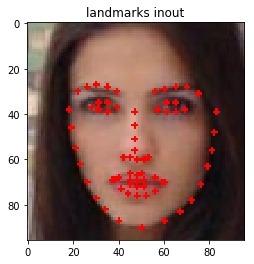

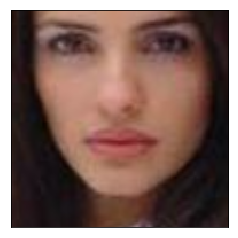

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


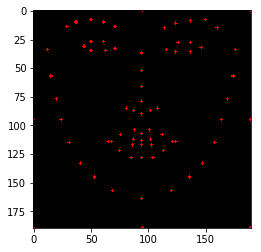

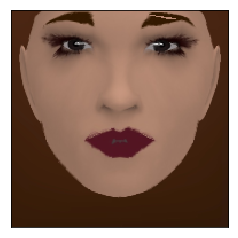

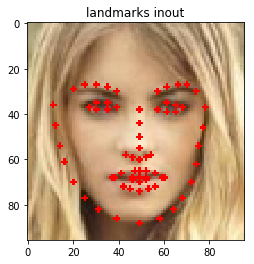

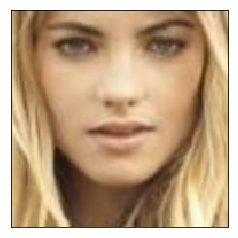

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


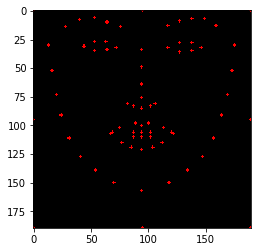

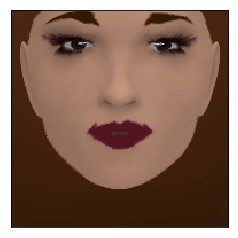

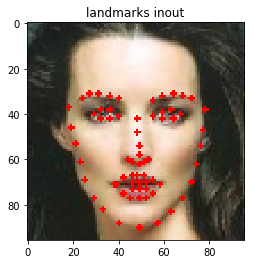

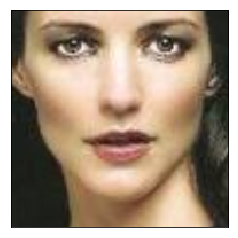

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


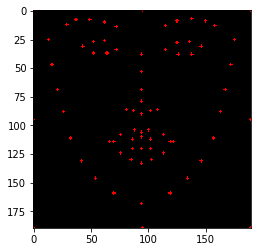

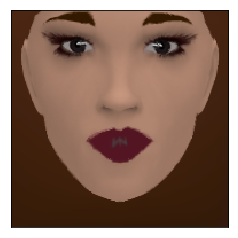

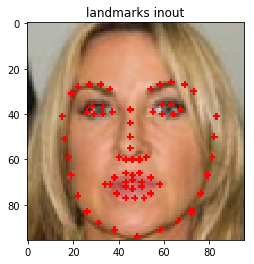

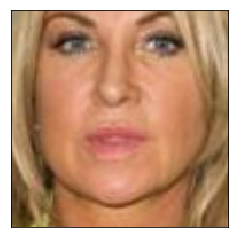

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


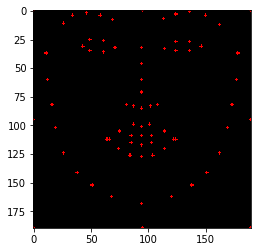

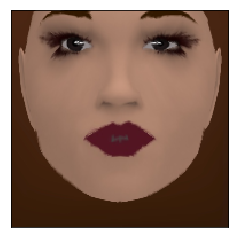

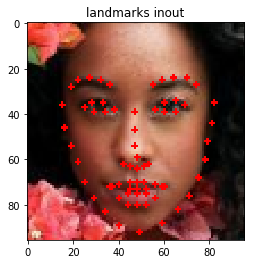

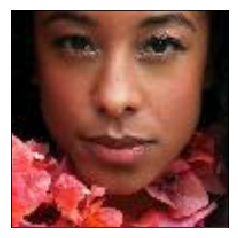

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


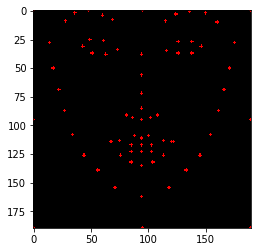

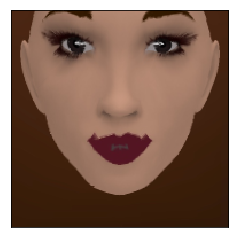

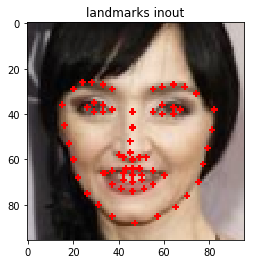

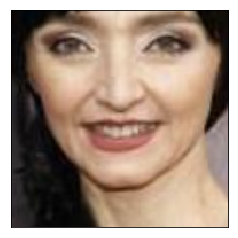

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


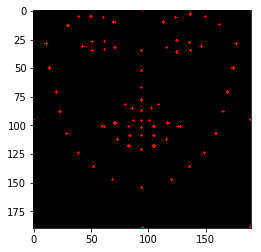

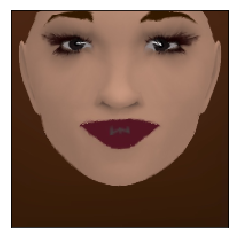

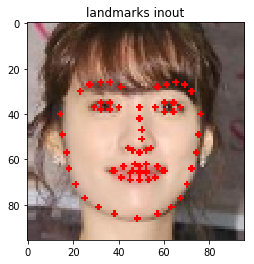

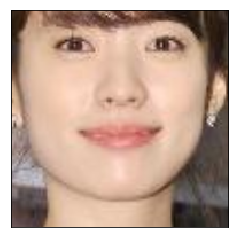

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


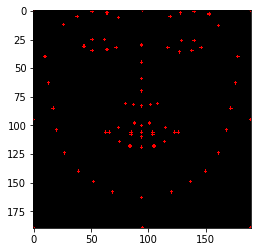

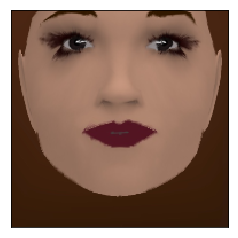

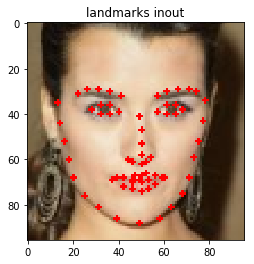

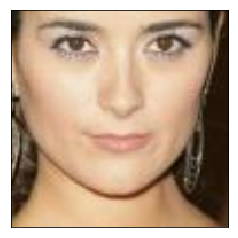

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


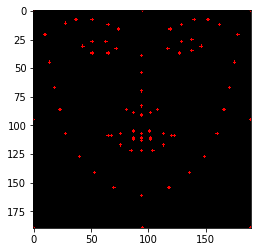

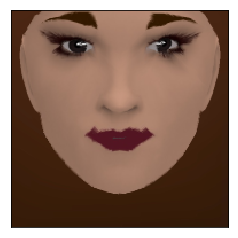

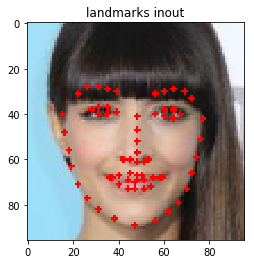

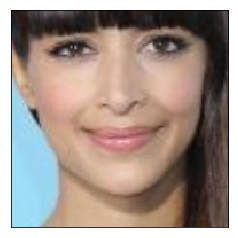

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


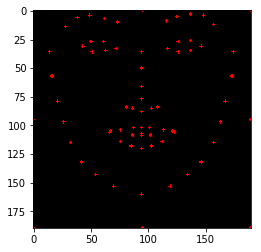

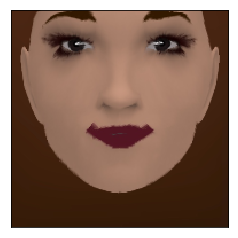

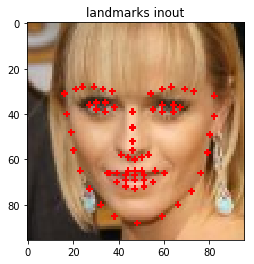

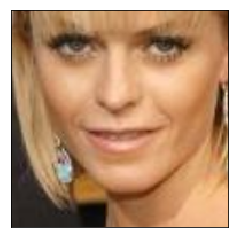

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


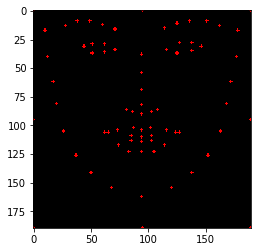

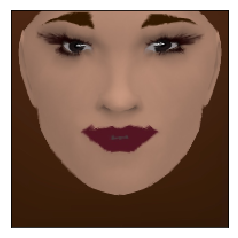

In [65]:
import os
import numpy as np
from image_lib import extract_patch, constrainPoint, similarityTransform, calculateDelaunayTriangles, applyAffineTransform, warpTriangle

img_dir = './data'
img_paths = os.listdir(img_dir)
final_w = 190
final_h = 190
# eye_corners_ref = [(np.float(0.3*final_w), np.float(final_h/3)), (np.float(0.7*final_w), np.float(final_h/3))]
eye_corners_ref = [(np.int(0.23*final_w), np.int(final_h/6)), (np.int(0.77*final_w), np.int(final_h/6))]

# boundary pts for delaunay triangulation
boundaryPts = np.array([(0,0), (final_w/2,0), (final_w-1,0), (final_w-1,final_h/2), 
                        (final_w-1, final_h-1 ), ( final_w/2, final_h-1 ), (0, final_h-1), (0,final_h/2) ])
landmark_size = 68

eye_corners_src = [landmarks[36], landmarks[45]]
tform = similarityTransform(eye_corners_src, eye_corners_ref)
plt.imshow(rgb_img)
plt.title('raw')
plt.show()
raw_img = cv2.warpAffine(rgb_img, tform, (final_w, final_h))
points2 = np.reshape(np.array(landmarks), (68, 1, 2))
raw_points = cv2.transform(points2, tform)
raw_points = np.float32(np.reshape(raw_points, (68, 2)))
raw_points = np.append(raw_points, boundaryPts, axis=0)
plt.imshow(raw_img)
# plt.title('raw')
plt.xticks([])
plt.yticks([])
plt.show()

def prune_landmark(landmarks, center_x):
    corner_pairs = [(0, 16), (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9), 
                    (31, 35), (32, 34),
                    (48, 54), (49, 53), (50, 52), (60, 64), (61, 63), (67, 65), (58, 56), (59, 55)]
    center_points = [8, 27, 28, 29, 30, 33, 51, 62, 66, 57]
    
    for ind0, ind1 in corner_pairs:
        l = landmarks[ind1][0] - landmarks[ind0][0]
        landmarks[ind1][0] = center_x + l/2
        landmarks[ind0][0] = center_x - l/2
        h = (landmarks[ind1][1] + landmarks[ind0][1])/2
        landmarks[ind1][1] = h
        landmarks[ind0][1] = h
    for ind in center_points:
        landmarks[ind][0] = center_x
    

for img_path in img_paths:
    full_img_path = os.path.join(img_dir, img_path)
    bgr_image = cv2.imread(full_img_path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    rgb_image_vis = rgb_image.copy()
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    face_rects = face_detector.detectMultiScale(gray_image, 1.3, 5)
    if len(face_rects) == 1:
        face_rect = face_rects[0]
        x, y, w, h = face_rect
        extend_ratio = 0.2
        extend_w = int(w * extend_ratio/2)
        extend_h = int(h * extend_ratio/2)
        ymin = y-extend_h
        xmin = x-extend_w
        xmax = x+w+extend_w
        ymax = y+h+extend_h
        face_crop_bgr = extract_patch(bgr_image, xmin, ymin, xmax, ymax)
        face_crop_original_rgb = cv2.cvtColor(face_crop_bgr.copy(), cv2.COLOR_BGR2RGB)
        face_crop_original_rgb_vis = cv2.cvtColor(face_crop_bgr.copy(), cv2.COLOR_BGR2RGB)
        
        original_shape = face_crop_bgr.shape
        face_crop_bgr = cv2.resize(face_crop_bgr, (refined_landmark_target_size))
        face_crop_rgb_vis = cv2.cvtColor(face_crop_bgr.copy(), cv2.COLOR_BGR2RGB)
        face_crop_bgr_in = ((face_crop_bgr / 255.0) - 0.5) * 2
        face_crop_bgr_in = np.expand_dims(face_crop_bgr_in, 0)
        refined_landmark_prediction = refined_landmark_inference.run(face_crop_bgr_in)

        face_landmarks_original = []
        face_landmarks_raw = []
        for i in range(68):
            face_landmarks_original.append([refined_landmark_prediction[0][0][i*2]/refined_landmark_target_size[0]*original_shape[0], 
                                            refined_landmark_prediction[0][0][i*2+1]/refined_landmark_target_size[1]*original_shape[1]])
            face_landmarks_raw.append([int(refined_landmark_prediction[0][0][i*2]/refined_landmark_target_size[0]*(w+extend_w*2)+x-extend_w), 
                                       int(refined_landmark_prediction[0][0][i*2+1]/refined_landmark_target_size[1]*(h+extend_h*2)+y-extend_h)])
#             face_landmarks_raw.append([refined_landmark_prediction[0][0][i*2]/refined_landmark_target_size[0]*(w+extend_w*2)+x-extend_w, 
#                                        refined_landmark_prediction[0][0][i*2+1]/refined_landmark_target_size[1]*(h+extend_h*2)+y-extend_h])
            
            cv2.circle(face_crop_original_rgb_vis, (int(face_landmarks_original[-1][0]),
                                                    int(face_landmarks_original[-1][1])),
                       1, (255), -1)
                        
            cv2.circle(rgb_image_vis, (int(face_landmarks_raw[-1][0]),
                                                    int(face_landmarks_raw[-1][1])),
                       1, (255), -1)
                                    
            cv2.circle(face_crop_rgb_vis, (int(refined_landmark_prediction[0][0][i*2]),
                                           int(refined_landmark_prediction[0][0][i*2+1])),
                       1, (255), -1)
#         plt.imshow(face_crop_original_rgb_vis)
#         plt.title('landmarks original')
#         plt.show()
#         plt.imshow(rgb_image_vis)
#         plt.title('landmarks raw')
#         plt.show()
        plt.imshow(face_crop_rgb_vis)
        plt.title('landmarks inout')
        plt.show()

        eye_corners_src = [face_landmarks_raw[36], face_landmarks_raw[45]]
        tform = similarityTransform(eye_corners_src, eye_corners_ref)
        img = cv2.warpAffine(rgb_image, tform, (final_w, final_h))
        points2 = np.reshape(np.array(face_landmarks_raw), (68, 1, 2))
        points = cv2.transform(points2, tform)
        points = np.float32(np.reshape(points, (68, 2)))
        prune_landmark(points, (final_w-1)/2)
        points = np.append(points, boundaryPts, axis=0)

        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        #plt.title('norm')
        plt.show()

        rect = (0, 0, final_w, final_h)
        img_null = np.zeros((final_h,final_w,3), np.float32());
        for x, y in points:
            cv2.circle(img_null, (int(x), int(y)), 1, (255, 0, 0), -1)
        plt.imshow(img_null)
        plt.show()

        dt = calculateDelaunayTriangles(rect, np.array(points))
        # Output image
        output = np.zeros((final_h,final_w,3), np.float32());

        img = np.zeros((final_h,final_w,3), np.float32());
        # Transform triangles one by one
        for j in range(0, len(dt)) :
            tin = []; 
            tout = [];
    #        img_null = np.zeros((final_h,final_w,3), np.float32());

            for k in range(0, 3) :                
                pIn = raw_points[dt[j][k]];
                pIn = constrainPoint(pIn, final_w, final_h);

                pOut = points[dt[j][k]];
                pOut = constrainPoint(pOut, final_w, final_h);

                tin.append(pIn);
                tout.append(pOut);

            warpTriangle(raw_img, img, tin, tout);
    #        warpTriangle(imagesNorm[i], img_null, tin, tout);
    #         plt.imshow(img_null/255.0)
    #         plt.title('{}, {}'.format(i, j))
    #         plt.show()


        # Add image intensities for averaging
        output = output + img;
    #     plt.imshow(output/(i+1)/255.0)
    #     plt.title('{}'.format(i))
    #     plt.show()


        # Divide by numImages to get average
        # Display result
        plt.imshow(output/255.0)
        plt.xticks([])
        plt.yticks([])

        plt.show()